In [1]:
import sys
from pathlib import Path

# Add the src directory to Python path
src_path = str(Path("./").resolve().parent.parent)
if src_path not in sys.path:
    sys.path.append(src_path)

sys.path

['/Library/Frameworks/Python.framework/Versions/3.11/lib/python311.zip',
 '/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11',
 '/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/lib-dynload',
 '',
 '/Users/anton/dev/MARS/correctness-model-internals/venv/lib/python3.11/site-packages',
 '/Users/anton/dev/MARS/correctness-model-internals']

In [2]:
from collections import defaultdict

import pandas as pd

from src.classifying import (
    ActivationsHandler,
    combine_activations_handlers,
    get_correctness_direction_classifier,
    get_logistic_regression_classifier,
    get_between_class_variance_and_within_class_variance,
)
from src.visualisations.utils import plot_interactive_lineplot
from src.utils.data import load_activations, load_labels, get_experiment_activations_configs_df_subset


In [3]:
BASE_PATH = "../../data_for_classification"
PCA_COMPONENTS = None

PCA_COMONENTS_LABEL = f"_pca_{PCA_COMPONENTS}" if PCA_COMPONENTS else ""

In [4]:
# Set None to get all
MODEL_ID = "llama3.1_8b_chat"
# DATASET_ID = "gsm8k"
# PROMPT_ID = "cot_3_shot"
# SUBSET_ID = "main"
# INPUT_TYPE = "prompt_only"
DATASET_ID = None
PROMPT_ID = None
SUBSET_ID = None
INPUT_TYPE = None

activation_exp_configs_df = get_experiment_activations_configs_df_subset(
    base_path=BASE_PATH,
    model_id=MODEL_ID,
    dataset_id=DATASET_ID,
    prompt_id=PROMPT_ID,
    subset_id=SUBSET_ID,
    input_type=INPUT_TYPE,
)
activation_exp_configs_df

,model_id,dataset_id,prompt_id,subset_id,input_type,layer,path
0,llama3.1_8b_chat,football_leagues_1k,base,main,prompt_only,0,../../data_for_classification/activations/llam...
1,llama3.1_8b_chat,football_leagues_1k,base,main,prompt_only,7,../../data_for_classification/activations/llam...
2,llama3.1_8b_chat,football_leagues_1k,base,main,prompt_only,9,../../data_for_classification/activations/llam...
3,llama3.1_8b_chat,football_leagues_1k,base,main,prompt_only,17,../../data_for_classification/activations/llam...
4,llama3.1_8b_chat,football_leagues_1k,base,main,prompt_only,28,../../data_for_classification/activations/llam...
...,...,...,...,...,...,...,...
379,llama3.1_8b_chat,birth_years_4k,base,main,prompt_answer,23,../../data_for_classification/activations/llam...
380,llama3.1_8b_chat,birth_years_4k,base,main,prompt_answer,15,../../data_for_classification/activations/llam...
381,llama3.1_8b_chat,birth_years_4k,base,main,prompt_answer,12,../../data_for_classification/activations/llam...
382,llama3.1_8b_chat,birth_years_4k,base,main,prompt_answer,2,../../data_for_classification/activations/llam...


In [5]:
activation_exp_configs_df["dataset_id"].unique()

array(['football_leagues_1k', 'medals_9k', 'gsm8k', 'cities_10k',
       'birth_years_4k'], dtype=object)

In [6]:
activation_exp_configs_df = activation_exp_configs_df[activation_exp_configs_df["dataset_id"].isin(["cities_10k", "birth_years_4k"])]
activation_exp_configs_df

,model_id,dataset_id,prompt_id,subset_id,input_type,layer,path
256,llama3.1_8b_chat,cities_10k,base,main,prompt_only,0,../../data_for_classification/activations/llam...
257,llama3.1_8b_chat,cities_10k,base,main,prompt_only,7,../../data_for_classification/activations/llam...
258,llama3.1_8b_chat,cities_10k,base,main,prompt_only,9,../../data_for_classification/activations/llam...
259,llama3.1_8b_chat,cities_10k,base,main,prompt_only,17,../../data_for_classification/activations/llam...
260,llama3.1_8b_chat,cities_10k,base,main,prompt_only,28,../../data_for_classification/activations/llam...
...,...,...,...,...,...,...,...
379,llama3.1_8b_chat,birth_years_4k,base,main,prompt_answer,23,../../data_for_classification/activations/llam...
380,llama3.1_8b_chat,birth_years_4k,base,main,prompt_answer,15,../../data_for_classification/activations/llam...
381,llama3.1_8b_chat,birth_years_4k,base,main,prompt_answer,12,../../data_for_classification/activations/llam...
382,llama3.1_8b_chat,birth_years_4k,base,main,prompt_answer,2,../../data_for_classification/activations/llam...


In [7]:

res_dict = defaultdict(list)

for input_type in ["prompt_only", "prompt_answer"]:
    activation_exp_configs_df_ = activation_exp_configs_df[activation_exp_configs_df["input_type"] == input_type]
    for (model_id_train, dataset_id_train, prompt_id_train, subset_id_train, input_type_train), _ in activation_exp_configs_df_.groupby(["model_id", "dataset_id", "prompt_id", "subset_id", "input_type"]):
        for (model_id_test, dataset_id_test, prompt_id_test, subset_id_test, input_type_test), config_df in activation_exp_configs_df_.groupby(["model_id", "dataset_id", "prompt_id", "subset_id", "input_type"]):
            print(f"\n{model_id_train=}, {dataset_id_train=}, {prompt_id_train=}, {subset_id_train=}, {input_type_train=}")
            print(f"\n{model_id_test=}, {dataset_id_test=}, {prompt_id_test=}, {subset_id_test=}, {input_type_test=}")
            labels_df_train = load_labels(
                base_path=BASE_PATH,
                model_id=model_id_train,
                dataset_id=dataset_id_train,
                prompt_id=prompt_id_train,
                subset_id=subset_id_train,
            )

            labels_df_test = load_labels(
                base_path=BASE_PATH,
                model_id=model_id_test,
                dataset_id=dataset_id_test,
                prompt_id=prompt_id_test,
                subset_id=subset_id_test,
            )

            check_indices_train, check_indices_test = None, None
            for layer in config_df["layer"].astype(int).sort_values():
                print(f"{layer=}", end=", ")
                activations_train, indices_train = load_activations(
                    base_path=BASE_PATH,
                    model_id=model_id_train,
                    dataset_id=dataset_id_train,
                    prompt_id=prompt_id_train,
                    subset_id=subset_id_train,
                    input_type=input_type_train,
                    layer=layer,
                )
                activations_test, indices_test = load_activations(
                    base_path=BASE_PATH,
                    model_id=model_id_test,
                    dataset_id=dataset_id_test,
                    prompt_id=prompt_id_test,
                    subset_id=subset_id_test,
                    input_type=input_type_test,
                    layer=layer,
                )
                
                if check_indices_train is None:
                    check_indices_train = indices_train.sample(frac=1, replace=False)
                
                if set(indices_train) != set(check_indices_train):
                    raise RuntimeError(f"indices across layers are not the same")

                labels_df_subset_train = labels_df_train.iloc[check_indices_train]
                activations_train = activations_train[check_indices_train]
                
                activations_handler_train = ActivationsHandler(
                    activations=activations_train,
                    labels=labels_df_subset_train["correct"].astype(bool),
                )

                activations_handler_folds_train = list(
                    activations_handler_train.split_dataset(split_sizes=[1/5] * 5)
                )

                if check_indices_test is None:
                    check_indices_test = indices_test.sample(frac=1, replace=False)
                
                if set(indices_test) != set(check_indices_test):
                    raise RuntimeError(f"indices across layers are not the same")


                labels_df_subset_test = labels_df_test.iloc[check_indices_test]
                activations_test = activations_test[check_indices_test]

                activations_handler_test = ActivationsHandler(
                    activations=activations_test,
                    labels=labels_df_subset_test["correct"].astype(bool),
                )

                activations_handler_folds_test = list(
                    activations_handler_test.split_dataset(split_sizes=[1/5] * 5)
                )

                fold_stats = {}
                for fold_i in range(5):
                    train_folds = [ah for j, ah in enumerate(activations_handler_folds_train) if j != fold_i]
                    activations_handler_test = activations_handler_folds_test[fold_i]
                # for fold_i, activations_handler_test in enumerate(activations_handler_folds_train):
                    activations_handler_train = combine_activations_handlers(
                        [ah for j, ah in enumerate(activations_handler_folds_train) if j != fold_i]
                    )
                    
                    activations_handler_train, pca_info = activations_handler_train.reduce_dims(pca_components=PCA_COMPONENTS)
                    
                    activations_handler_train = activations_handler_train.sample_equally_across_groups(
                        group_labels=[False, True]
                    )
                    activations_handler_test, _ = activations_handler_test.reduce_dims(pca_components=PCA_COMPONENTS, pca_info=pca_info)
                    activations_handler_test = activations_handler_test.sample_equally_across_groups(
                        group_labels=[False, True]
                    )

                    res_dict["model_id_train"].append(model_id_train)
                    res_dict["dataset_id_train"].append(dataset_id_train)
                    res_dict["prompt_id_train"].append(prompt_id_train)
                    res_dict["subset_id_train"].append(subset_id_train)
                    res_dict["input_type_train"].append(input_type_train)
                    res_dict["model_id_test"].append(model_id_test)
                    res_dict["dataset_id_test"].append(dataset_id_test)
                    res_dict["prompt_id_test"].append(prompt_id_test)
                    res_dict["subset_id_test"].append(subset_id_test)
                    res_dict["input_type_test"].append(input_type_test)
                    res_dict["layer"].append(layer)
                    res_dict["fold"].append(fold_i)

                    direction_classifier, direction_calculator = get_correctness_direction_classifier(
                        activations_handler_train=activations_handler_train,
                        activations_handler_test=activations_handler_test,
                    )
                    # res_dict["classifying_direction"].append(direction_calculator.classifying_direction.tolist())
                    for key, value in direction_classifier.classification_metrics.items():
                        res_dict[f"direction_{key}"].append(value)
                    
                    for key, value in get_logistic_regression_classifier(
                            activations_handler_train=activations_handler_train,
                            activations_handler_test=activations_handler_test,
                        )[0].classification_metrics.items():
                        res_dict[f"logistic_regression_{key}"].append(value)



res_df = pd.DataFrame(res_dict)
res_df


model_id_train='llama3.1_8b_chat', dataset_id_train='birth_years_4k', prompt_id_train='base', subset_id_train='main', input_type_train='prompt_only'

model_id_test='llama3.1_8b_chat', dataset_id_test='birth_years_4k', prompt_id_test='base', subset_id_test='main', input_type_test='prompt_only'
layer=0, 

/Users/anton/dev/MARS/correctness-model-internals/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/anton/dev/MARS/correctness-model-internals/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https

layer=1, layer=2, layer=3, layer=4, layer=5, layer=6, layer=7, layer=8, layer=9, layer=10, layer=11, layer=12, layer=13, layer=14, layer=15, layer=16, layer=17, layer=18, layer=19, layer=20, layer=21, layer=22, layer=23, layer=24, layer=25, layer=26, layer=27, layer=28, layer=29, layer=30, layer=31, 
model_id_train='llama3.1_8b_chat', dataset_id_train='birth_years_4k', prompt_id_train='base', subset_id_train='main', input_type_train='prompt_only'

model_id_test='llama3.1_8b_chat', dataset_id_test='cities_10k', prompt_id_test='base', subset_id_test='main', input_type_test='prompt_only'
layer=0, 

/Users/anton/dev/MARS/correctness-model-internals/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


layer=1, layer=2, layer=3, layer=4, layer=5, layer=6, layer=7, layer=8, layer=9, layer=10, layer=11, layer=12, layer=13, layer=14, layer=15, layer=16, layer=17, layer=18, layer=19, layer=20, layer=21, layer=22, layer=23, layer=24, layer=25, layer=26, layer=27, layer=28, layer=29, layer=30, layer=31, 
model_id_train='llama3.1_8b_chat', dataset_id_train='cities_10k', prompt_id_train='base', subset_id_train='main', input_type_train='prompt_only'

model_id_test='llama3.1_8b_chat', dataset_id_test='birth_years_4k', prompt_id_test='base', subset_id_test='main', input_type_test='prompt_only'
layer=0, 

/Users/anton/dev/MARS/correctness-model-internals/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/anton/dev/MARS/correctness-model-internals/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https

layer=1, 

/Users/anton/dev/MARS/correctness-model-internals/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/anton/dev/MARS/correctness-model-internals/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https

layer=2, 

/Users/anton/dev/MARS/correctness-model-internals/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/anton/dev/MARS/correctness-model-internals/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https

layer=3, 

/Users/anton/dev/MARS/correctness-model-internals/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/anton/dev/MARS/correctness-model-internals/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https

layer=4, layer=5, layer=6, layer=7, layer=8, layer=9, layer=10, layer=11, layer=12, layer=13, layer=14, layer=15, layer=16, layer=17, layer=18, layer=19, layer=20, layer=21, layer=22, layer=23, layer=24, layer=25, layer=26, layer=27, layer=28, layer=29, layer=30, layer=31, 
model_id_train='llama3.1_8b_chat', dataset_id_train='cities_10k', prompt_id_train='base', subset_id_train='main', input_type_train='prompt_only'

model_id_test='llama3.1_8b_chat', dataset_id_test='cities_10k', prompt_id_test='base', subset_id_test='main', input_type_test='prompt_only'
layer=0, 

/Users/anton/dev/MARS/correctness-model-internals/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/anton/dev/MARS/correctness-model-internals/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https

layer=1, 

/Users/anton/dev/MARS/correctness-model-internals/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/anton/dev/MARS/correctness-model-internals/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https

layer=2, 

/Users/anton/dev/MARS/correctness-model-internals/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/anton/dev/MARS/correctness-model-internals/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https

layer=3, 

/Users/anton/dev/MARS/correctness-model-internals/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/anton/dev/MARS/correctness-model-internals/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https

layer=4, layer=5, layer=6, layer=7, layer=8, layer=9, layer=10, layer=11, layer=12, layer=13, layer=14, layer=15, layer=16, layer=17, layer=18, layer=19, layer=20, layer=21, layer=22, layer=23, layer=24, layer=25, layer=26, layer=27, layer=28, layer=29, layer=30, layer=31, 
model_id_train='llama3.1_8b_chat', dataset_id_train='birth_years_4k', prompt_id_train='base', subset_id_train='main', input_type_train='prompt_answer'

model_id_test='llama3.1_8b_chat', dataset_id_test='birth_years_4k', prompt_id_test='base', subset_id_test='main', input_type_test='prompt_answer'
layer=0, 

/Users/anton/dev/MARS/correctness-model-internals/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/anton/dev/MARS/correctness-model-internals/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https

layer=1, 

/Users/anton/dev/MARS/correctness-model-internals/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/anton/dev/MARS/correctness-model-internals/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https

layer=2, 

/Users/anton/dev/MARS/correctness-model-internals/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/anton/dev/MARS/correctness-model-internals/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https

layer=3, layer=4, layer=5, layer=6, layer=7, layer=8, layer=9, layer=10, layer=11, layer=12, layer=13, layer=14, layer=15, layer=16, layer=17, layer=18, layer=19, layer=20, layer=21, layer=22, layer=23, layer=24, layer=25, layer=26, layer=27, layer=28, layer=29, layer=30, layer=31, 
model_id_train='llama3.1_8b_chat', dataset_id_train='birth_years_4k', prompt_id_train='base', subset_id_train='main', input_type_train='prompt_answer'

model_id_test='llama3.1_8b_chat', dataset_id_test='cities_10k', prompt_id_test='base', subset_id_test='main', input_type_test='prompt_answer'
layer=0, 

/Users/anton/dev/MARS/correctness-model-internals/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/anton/dev/MARS/correctness-model-internals/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https

layer=1, 

/Users/anton/dev/MARS/correctness-model-internals/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/anton/dev/MARS/correctness-model-internals/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https

layer=2, 

/Users/anton/dev/MARS/correctness-model-internals/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


layer=3, layer=4, layer=5, layer=6, layer=7, layer=8, layer=9, layer=10, layer=11, layer=12, layer=13, layer=14, layer=15, layer=16, layer=17, layer=18, 

/Users/anton/dev/MARS/correctness-model-internals/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


layer=19, layer=20, layer=21, layer=22, layer=23, 

/Users/anton/dev/MARS/correctness-model-internals/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


layer=24, 

/Users/anton/dev/MARS/correctness-model-internals/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


layer=25, 

/Users/anton/dev/MARS/correctness-model-internals/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


layer=26, 

/Users/anton/dev/MARS/correctness-model-internals/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/anton/dev/MARS/correctness-model-internals/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


layer=27, 

/Users/anton/dev/MARS/correctness-model-internals/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


layer=28, 

/Users/anton/dev/MARS/correctness-model-internals/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/anton/dev/MARS/correctness-model-internals/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


layer=29, 

/Users/anton/dev/MARS/correctness-model-internals/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/anton/dev/MARS/correctness-model-internals/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


layer=30, 

/Users/anton/dev/MARS/correctness-model-internals/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


layer=31, 
model_id_train='llama3.1_8b_chat', dataset_id_train='cities_10k', prompt_id_train='base', subset_id_train='main', input_type_train='prompt_answer'

model_id_test='llama3.1_8b_chat', dataset_id_test='birth_years_4k', prompt_id_test='base', subset_id_test='main', input_type_test='prompt_answer'
layer=0, 

/Users/anton/dev/MARS/correctness-model-internals/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/anton/dev/MARS/correctness-model-internals/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https

layer=1, 

/Users/anton/dev/MARS/correctness-model-internals/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/anton/dev/MARS/correctness-model-internals/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https

layer=2, 

/Users/anton/dev/MARS/correctness-model-internals/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/anton/dev/MARS/correctness-model-internals/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https

layer=3, 

/Users/anton/dev/MARS/correctness-model-internals/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/anton/dev/MARS/correctness-model-internals/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https

layer=4, layer=5, layer=6, layer=7, layer=8, layer=9, 

/Users/anton/dev/MARS/correctness-model-internals/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/anton/dev/MARS/correctness-model-internals/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


layer=10, layer=11, layer=12, layer=13, layer=14, layer=15, layer=16, layer=17, layer=18, layer=19, layer=20, layer=21, layer=22, layer=23, layer=24, layer=25, layer=26, layer=27, layer=28, layer=29, layer=30, layer=31, 
model_id_train='llama3.1_8b_chat', dataset_id_train='cities_10k', prompt_id_train='base', subset_id_train='main', input_type_train='prompt_answer'

model_id_test='llama3.1_8b_chat', dataset_id_test='cities_10k', prompt_id_test='base', subset_id_test='main', input_type_test='prompt_answer'
layer=0, 

/Users/anton/dev/MARS/correctness-model-internals/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/anton/dev/MARS/correctness-model-internals/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https

layer=1, 

/Users/anton/dev/MARS/correctness-model-internals/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/anton/dev/MARS/correctness-model-internals/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https

layer=2, 

/Users/anton/dev/MARS/correctness-model-internals/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/anton/dev/MARS/correctness-model-internals/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https

layer=3, 

/Users/anton/dev/MARS/correctness-model-internals/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/anton/dev/MARS/correctness-model-internals/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https

layer=4, layer=5, layer=6, layer=7, layer=8, layer=9, layer=10, layer=11, layer=12, layer=13, layer=14, layer=15, layer=16, layer=17, layer=18, layer=19, layer=20, layer=21, layer=22, layer=23, layer=24, layer=25, layer=26, layer=27, layer=28, layer=29, layer=30, layer=31, 

,model_id_train,dataset_id_train,prompt_id_train,subset_id_train,input_type_train,model_id_test,dataset_id_test,prompt_id_test,subset_id_test,input_type_test,...,direction_f1_score,direction_precision_score,direction_recall_score,logistic_regression_optimal_cut,logistic_regression_optimal_train_set_cut,logistic_regression_test_roc_auc,logistic_regression_accuracy_score,logistic_regression_f1_score,logistic_regression_precision_score,logistic_regression_recall_score
0,llama3.1_8b_chat,birth_years_4k,base,main,prompt_only,llama3.1_8b_chat,birth_years_4k,base,main,prompt_only,...,0.356589,0.766667,0.232323,0.5,0.557746,0.755408,0.717172,0.683616,0.775641,0.611111
1,llama3.1_8b_chat,birth_years_4k,base,main,prompt_only,llama3.1_8b_chat,birth_years_4k,base,main,prompt_only,...,0.378947,0.593407,0.278351,0.5,0.458819,0.764786,0.706186,0.670520,0.763158,0.597938
2,llama3.1_8b_chat,birth_years_4k,base,main,prompt_only,llama3.1_8b_chat,birth_years_4k,base,main,prompt_only,...,0.356643,0.554348,0.262887,0.5,0.476146,0.733075,0.698454,0.672269,0.736196,0.618557
3,llama3.1_8b_chat,birth_years_4k,base,main,prompt_only,llama3.1_8b_chat,birth_years_4k,base,main,prompt_only,...,0.416357,0.674699,0.301075,0.5,0.455187,0.769193,0.720430,0.695906,0.762821,0.639785
4,llama3.1_8b_chat,birth_years_4k,base,main,prompt_only,llama3.1_8b_chat,birth_years_4k,base,main,prompt_only,...,0.350877,0.549451,0.257732,0.5,0.467110,0.742002,0.695876,0.654971,0.756757,0.577320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1275,llama3.1_8b_chat,cities_10k,base,main,prompt_answer,llama3.1_8b_chat,cities_10k,base,main,prompt_answer,...,0.658296,0.627350,0.692453,0.5,0.520977,0.925979,0.872642,0.869817,0.889546,0.850943
1276,llama3.1_8b_chat,cities_10k,base,main,prompt_answer,llama3.1_8b_chat,cities_10k,base,main,prompt_answer,...,0.638596,0.610738,0.669118,0.5,0.556960,0.935221,0.877757,0.874647,0.897485,0.852941
1277,llama3.1_8b_chat,cities_10k,base,main,prompt_answer,llama3.1_8b_chat,cities_10k,base,main,prompt_answer,...,0.654832,0.640927,0.669355,0.5,0.481759,0.934039,0.868952,0.865424,0.889362,0.842742
1278,llama3.1_8b_chat,cities_10k,base,main,prompt_answer,llama3.1_8b_chat,cities_10k,base,main,prompt_answer,...,0.616935,0.642857,0.593023,0.5,0.531292,0.921076,0.866279,0.857143,0.920000,0.802326


In [8]:
res_file = f"./classification_data/res_df_llama31_8B_train_test_different_datasets{PCA_COMONENTS_LABEL}.csv"

In [9]:
res_df.to_csv(res_file, index=False)

In [10]:
res_df = pd.read_csv(res_file)

In [13]:
for classifier in ["direction", "logistic_regression"]:
    # for metric in ["f1_score", "accuracy_score", "precision_score", "recall_score", "test_roc_auc"]:
    for metric in ["test_roc_auc"]:
        plot_dict = {}
        for conf, res_df_ in res_df.groupby([
            "model_id_train", 
            "dataset_id_train", 
            "prompt_id_train", 
            "subset_id_train", 
            "input_type_train",
            "model_id_test",
            "dataset_id_test",
            "prompt_id_test",
            "subset_id_test",
            "input_type_test"
        ]):
            # if conf[4] != "prompt_only":
            #     continue
            
            print(f"{conf=}")
            res_df_pivot = pd.pivot(
                res_df_.drop(columns=[
                    "model_id_train",
                    "dataset_id_train",
                    "prompt_id_train",
                    "subset_id_train",
                    "input_type_train",
                    "model_id_test",
                    "dataset_id_test",
                    "prompt_id_test",
                    "subset_id_test",
                    "input_type_test"
                ]),
                index='layer',
                columns='fold',
                # values=['direction_f1_score', 'logistic_regression_f1_score']  # add all metrics you want to keep
            )
            # for classifier in ["direction", "logistic_regression"]:
            #     for metric in ["f1_score", "accuracy_score", "precision_score", "recall_score"]:
            plot_dict[str(conf)] = res_df_pivot[[f"{classifier}_{metric}"]]

        plot_interactive_lineplot(
            plot_dict,
            x_label="Layer",
            y_label=f"{classifier}_{metric}".replace("_", " ").title(),
            save_path=f"./classification_data/figures/llama31_8B_train_test_different_datasets{classifier}_{metric}{PCA_COMONENTS_LABEL}.html"
        ).show()



conf=('llama3.1_8b_chat', 'birth_years_4k', 'base', 'main', 'prompt_answer', 'llama3.1_8b_chat', 'birth_years_4k', 'base', 'main', 'prompt_answer')
conf=('llama3.1_8b_chat', 'birth_years_4k', 'base', 'main', 'prompt_answer', 'llama3.1_8b_chat', 'cities_10k', 'base', 'main', 'prompt_answer')
conf=('llama3.1_8b_chat', 'birth_years_4k', 'base', 'main', 'prompt_only', 'llama3.1_8b_chat', 'birth_years_4k', 'base', 'main', 'prompt_only')
conf=('llama3.1_8b_chat', 'birth_years_4k', 'base', 'main', 'prompt_only', 'llama3.1_8b_chat', 'cities_10k', 'base', 'main', 'prompt_only')
conf=('llama3.1_8b_chat', 'cities_10k', 'base', 'main', 'prompt_answer', 'llama3.1_8b_chat', 'birth_years_4k', 'base', 'main', 'prompt_answer')
conf=('llama3.1_8b_chat', 'cities_10k', 'base', 'main', 'prompt_answer', 'llama3.1_8b_chat', 'cities_10k', 'base', 'main', 'prompt_answer')
conf=('llama3.1_8b_chat', 'cities_10k', 'base', 'main', 'prompt_only', 'llama3.1_8b_chat', 'birth_years_4k', 'base', 'main', 'prompt_only')


conf=('llama3.1_8b_chat', 'birth_years_4k', 'base', 'main', 'prompt_answer', 'llama3.1_8b_chat', 'birth_years_4k', 'base', 'main', 'prompt_answer')
conf=('llama3.1_8b_chat', 'birth_years_4k', 'base', 'main', 'prompt_answer', 'llama3.1_8b_chat', 'cities_10k', 'base', 'main', 'prompt_answer')
conf=('llama3.1_8b_chat', 'birth_years_4k', 'base', 'main', 'prompt_only', 'llama3.1_8b_chat', 'birth_years_4k', 'base', 'main', 'prompt_only')
conf=('llama3.1_8b_chat', 'birth_years_4k', 'base', 'main', 'prompt_only', 'llama3.1_8b_chat', 'cities_10k', 'base', 'main', 'prompt_only')
conf=('llama3.1_8b_chat', 'cities_10k', 'base', 'main', 'prompt_answer', 'llama3.1_8b_chat', 'birth_years_4k', 'base', 'main', 'prompt_answer')
conf=('llama3.1_8b_chat', 'cities_10k', 'base', 'main', 'prompt_answer', 'llama3.1_8b_chat', 'cities_10k', 'base', 'main', 'prompt_answer')
conf=('llama3.1_8b_chat', 'cities_10k', 'base', 'main', 'prompt_only', 'llama3.1_8b_chat', 'birth_years_4k', 'base', 'main', 'prompt_only')


In [18]:
input_type_train

'prompt_answer'

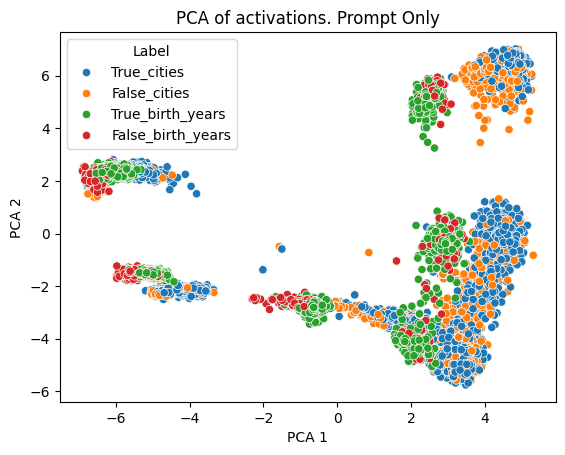

In [37]:
from src.visualisations.utils import visualise_clusters_dimenstionality_reduction

labels_df_cities = load_labels(
    base_path=BASE_PATH,
    model_id='llama3.1_8b_chat',
    dataset_id='cities_10k',
    prompt_id='base',
    subset_id='main',
)

activations_cities, _ = load_activations(
    base_path=BASE_PATH,
    model_id='llama3.1_8b_chat',
    dataset_id='cities_10k',
    prompt_id='base',
    subset_id='main',
    input_type='prompt_only',
    # input_type='prompt_answer',
    layer=18,
)

labels_df_birth_years = load_labels(
    base_path=BASE_PATH,
    model_id='llama3.1_8b_chat',
    dataset_id='birth_years_4k',
    prompt_id='base',
    subset_id='main',
)

activations_birth_years, _ = load_activations(
    base_path=BASE_PATH,
    model_id='llama3.1_8b_chat',
    dataset_id='birth_years_4k',
    prompt_id='base',
    subset_id='main',
    input_type='prompt_only',
    # input_type='prompt_answer',
    layer=18,
)

ah_cities = ActivationsHandler(
    activations=activations_cities,
    labels=labels_df_cities["correct"].astype(bool).astype(str) + "_cities",
)

ah_birth_years = ActivationsHandler(
    activations=activations_birth_years,
    labels=labels_df_birth_years["correct"].astype(bool).astype(str) + "_birth_years",
)

ah, _ = combine_activations_handlers([ah_cities, ah_birth_years]).reduce_dims(pca_components=2)

import seaborn as sns
ax = sns.scatterplot(
    x=ah.activations[:, 0],
    y=ah.activations[:, 1],
    hue=ah.labels,
)
ax.set_title("PCA of activations. Prompt Only")
# ax.set_title("PCA of activations. Prompt and answer")
ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.legend(title="Label")